In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Initial setup for audio processing, data balancing, and deep learning
!pip install librosa kaggle imbalanced-learn scikit-learn tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [4]:
# Load the MIT-BIH Arrhythmia Database
# Train and test datasets from Kaggle
train_data = pd.read_csv('drive/MyDrive/ecg_data/mitbih_train.csv', header=None)
test_data = pd.read_csv('drive/MyDrive/ecg_data/mitbih_test.csv', header=None)

print(f"✓ Training data loaded: Shape = {train_data.shape}")
print(f"✓ Test data loaded: Shape = {test_data.shape}")
print(f"\nDataset Overview:")
print(f"  - Total ECG samples: {train_data.shape[0] + test_data.shape[0]}")
print(f"  - ECG signal length: {train_data.shape[1] - 1} time points")
print(f"  - Last column contains class labels (0-4)")

# Display first few rows
print(f"\nFirst 3 rows of training data:")
print(train_data.head(3))

✓ Training data loaded: Shape = (87554, 188)
✓ Test data loaded: Shape = (21892, 188)

Dataset Overview:
  - Total ECG samples: 109446
  - ECG signal length: 187 time points
  - Last column contains class labels (0-4)

First 3 rows of training data:
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  

[3 rows x 188 columns]


In [5]:
# Extract features and labels from training data
X_train_full = train_data.iloc[:, :-1].values  # All columns except last
y_train_full = train_data.iloc[:, -1].values   # Last column (labels)

# Extract features and labels from test data
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Convert multi-class labels to binary: 0 = Normal, 1-4 = Abnormal → 1
y_train_binary = (y_train_full > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

print("✓ Binary Label Conversion Complete")
print(f"\nLabel Distribution (Original Multi-class):")
print(f"  Training: {np.unique(y_train_full, return_counts=True)}")
print(f"  Test: {np.unique(y_test, return_counts=True)}")

print(f"\nLabel Distribution (Binary - 0=Normal, 1=Abnormal):")
unique_train, counts_train = np.unique(y_train_binary, return_counts=True)
unique_test, counts_test = np.unique(y_test_binary, return_counts=True)
print(f"  Training - Normal: {counts_train[0]}, Abnormal: {counts_train[1]}")
print(f"  Test - Normal: {counts_test[0]}, Abnormal: {counts_test[1]}")

✓ Binary Label Conversion Complete

Label Distribution (Original Multi-class):
  Training: (array([0., 1., 2., 3., 4.]), array([72471,  2223,  5788,   641,  6431]))
  Test: (array([0., 1., 2., 3., 4.]), array([18118,   556,  1448,   162,  1608]))

Label Distribution (Binary - 0=Normal, 1=Abnormal):
  Training - Normal: 72471, Abnormal: 15083
  Test - Normal: 18118, Abnormal: 3774


In [6]:
# Reshape data to (Samples, 187, 1) for 1D-CNN
X_train_reshaped = X_train_full.reshape(-1, 187, 1)
X_test_reshaped = X_test.reshape(-1, 187, 1)

print("✓ Data Reshaping Complete for 1D-CNN")
print(f"\nOriginal shape: {X_train_full.shape}")
print(f"Reshaped shape: {X_train_reshaped.shape}")
print(f"\nTest data reshaped: {X_test_reshaped.shape}")
print(f"\nData is ready for 1D-CNN architecture")

✓ Data Reshaping Complete for 1D-CNN

Original shape: (87554, 187)
Reshaped shape: (87554, 187, 1)

Test data reshaped: (21892, 187, 1)

Data is ready for 1D-CNN architecture


In [7]:
# ⚠️ CRITICAL: Perform stratified split BEFORE resampling to prevent data leakage
X_train, X_val, y_train, y_val = train_test_split(
    X_train_reshaped,
    y_train_binary,
    test_size=0.2,
    random_state=42,
    stratify=y_train_binary
)

print("✓ Stratified Train-Validation Split Complete (80-20)")
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test_reshaped.shape[0]} samples")

print(f"\nClass distribution preserved:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)
print(f"  Training - Normal: {counts_train[0]}, Abnormal: {counts_train[1]}")
print(f"  Validation - Normal: {counts_val[0]}, Abnormal: {counts_val[1]}")
print(f"  Train ratio (Normal:Abnormal) = {counts_train[0]/counts_train[1]:.3f}")
print(f"  Val ratio (Normal:Abnormal) = {counts_val[0]/counts_val[1]:.3f}")

✓ Stratified Train-Validation Split Complete (80-20)

Training set: 70043 samples
Validation set: 17511 samples
Test set: 21892 samples

Class distribution preserved:
  Training - Normal: 57977, Abnormal: 12066
  Validation - Normal: 14494, Abnormal: 3017
  Train ratio (Normal:Abnormal) = 4.805
  Val ratio (Normal:Abnormal) = 4.804


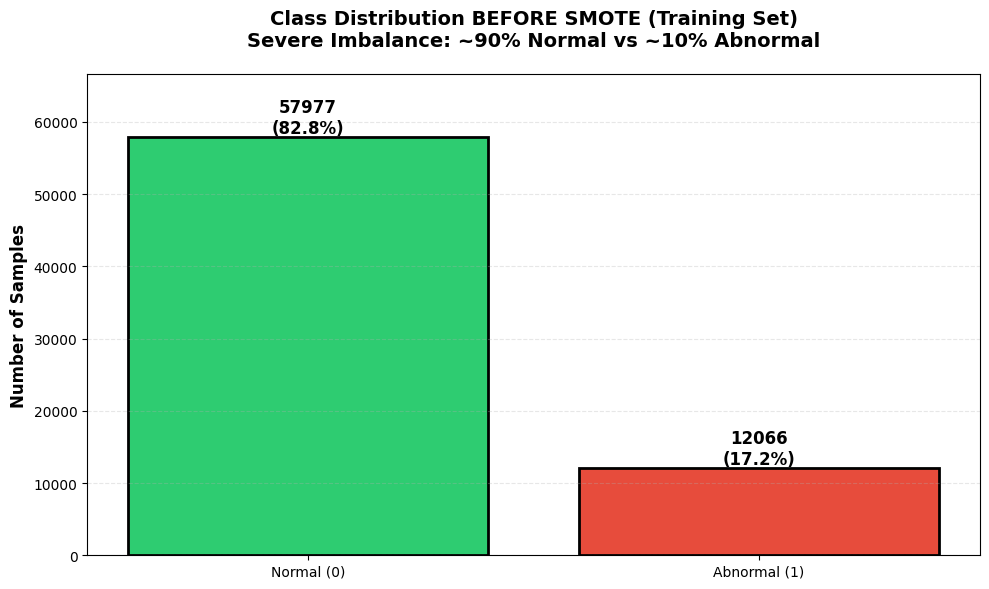

✓ Class Imbalance Visualization Complete

Imbalance Ratio: 4.80:1 (Normal:Abnormal)


In [8]:
# Visualize class imbalance BEFORE SMOTE
unique_before, counts_before = np.unique(y_train, return_counts=True)

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(['Normal (0)', 'Abnormal (1)'], counts_before, color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(y_train)*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution BEFORE SMOTE (Training Set)\nSevere Imbalance: ~90% Normal vs ~10% Abnormal',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, max(counts_before) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"✓ Class Imbalance Visualization Complete")
print(f"\nImbalance Ratio: {counts_before[0]/counts_before[1]:.2f}:1 (Normal:Abnormal)")

In [9]:
# Apply SMOTE to training set only (NO RESAMPLING on validation/test)
# Flatten data for SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote_flat, y_train_smote = smote.fit_resample(X_train_flat, y_train)

# Reshape back to 3D for CNN
X_train_smote = X_train_smote_flat.reshape(-1, 187, 1)

print("✓ SMOTE Applied to Training Set")
print(f"\nBefore SMOTE: {X_train.shape[0]} samples")
print(f"After SMOTE: {X_train_smote.shape[0]} samples")
print(f"\nClass distribution after SMOTE:")
unique_after, counts_after = np.unique(y_train_smote, return_counts=True)
print(f"  Normal (0): {counts_after[0]}")
print(f"  Abnormal (1): {counts_after[1]}")
print(f"  Ratio: 1:{counts_after[1]/counts_after[0]:.3f}")

✓ SMOTE Applied to Training Set

Before SMOTE: 70043 samples
After SMOTE: 115954 samples

Class distribution after SMOTE:
  Normal (0): 57977
  Abnormal (1): 57977
  Ratio: 1:1.000


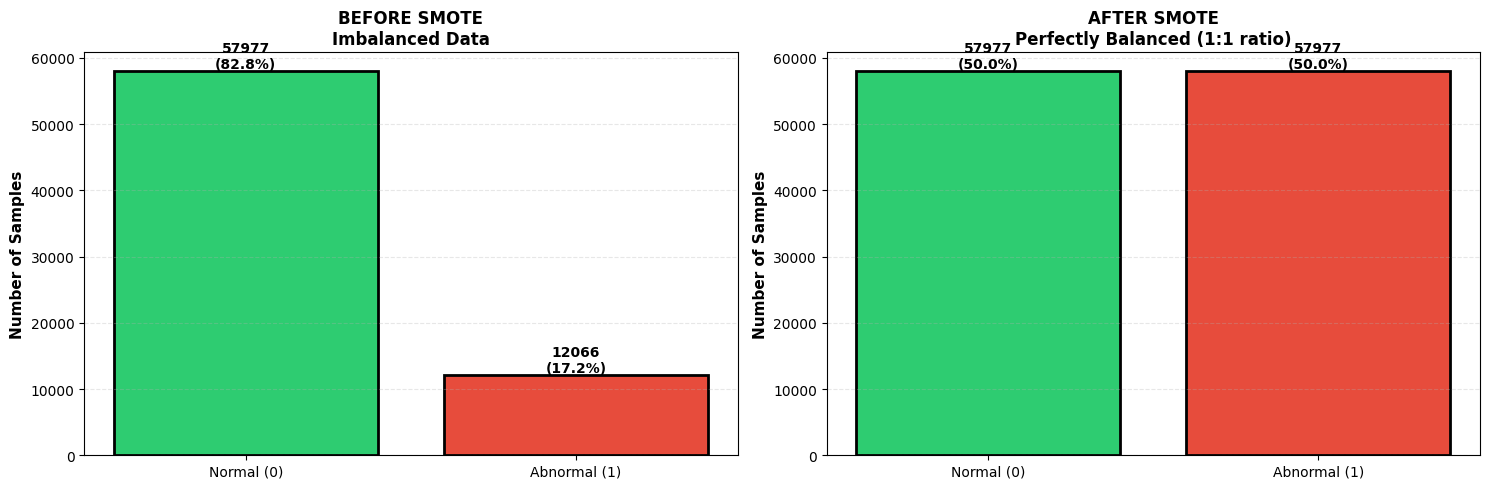

✓ SMOTE Effectiveness Confirmed!

Imbalance Ratio Change:
  Before: 4.80:1
  After: 1.00:1


In [10]:
# Visualize balanced classes AFTER SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before SMOTE
axes[0].bar(['Normal (0)', 'Abnormal (1)'], counts_before, color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[0].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0].set_title('BEFORE SMOTE\nImbalanced Data', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, (bar, count) in enumerate(zip(axes[0].patches, counts_before)):
    axes[0].text(bar.get_x() + bar.get_width()/2., count,
                f'{int(count)}\n({count/len(y_train)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# After SMOTE
axes[1].bar(['Normal (0)', 'Abnormal (1)'], counts_after, color=['#2ecc71', '#e74c3c'], edgecolor='black', linewidth=2)
axes[1].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1].set_title('AFTER SMOTE\nPerfectly Balanced (1:1 ratio)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, (bar, count) in enumerate(zip(axes[1].patches, counts_after)):
    axes[1].text(bar.get_x() + bar.get_width()/2., count,
                f'{int(count)}\n({count/len(y_train_smote)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✓ SMOTE Effectiveness Confirmed!")
print(f"\nImbalance Ratio Change:")
print(f"  Before: {counts_before[0]/counts_before[1]:.2f}:1")
print(f"  After: {counts_after[0]/counts_after[1]:.2f}:1")

In [11]:
# Build 1D-CNN model for ECG classification
model = models.Sequential([
    # First Conv Block
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(187, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Second Conv Block
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Third Conv Block
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # Flatten and Dense
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Display model architecture
model.summary()
print("\n✓ 1D-CNN Model Architecture Created Successfully")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 93, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 93, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2944)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       188,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,481 (861.25 KB)

 Trainable params: 220,033 (859.50 KB)

 Non-trainable params: 448 (1.75 KB)


✓ 1D-CNN Model Architecture Created Successfully


In [12]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✓ Model Compiled Successfully")
print(f"\nOptimizer: Adam (lr=0.001)")
print(f"Loss Function: binary_crossentropy")
print(f"Metrics: accuracy")

✓ Model Compiled Successfully

Optimizer: Adam (lr=0.001)
Loss Function: binary_crossentropy
Metrics: accuracy


In [13]:
# Define EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model on SMOTE-balanced training data
print("🚀 Training the 1D-CNN model...\n")
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ Model Training Complete!")

🚀 Training the 1D-CNN model...

Epoch 1/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.8820 - loss: 0.2749 - val_accuracy: 0.9664 - val_loss: 0.0985
Epoch 2/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9565 - loss: 0.1174 - val_accuracy: 0.9463 - val_loss: 0.1473
Epoch 3/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9678 - loss: 0.0894 - val_accuracy: 0.9724 - val_loss: 0.0804
Epoch 4/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9711 - loss: 0.0809 - val_accuracy: 0.9812 - val_loss: 0.0531
Epoch 5/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9748 - loss: 0.0726 - val_accuracy: 0.9792 - val_loss: 0.0637
Epoch 6/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9775 - loss: 0.0647 - val_accuracy: 0.9847 - val_loss: 0.0468
Epoch 7/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9781 - loss: 0.0614 - val_accuracy: 0.9814 - val_loss: 0.0592
Epoch 8/50
3624/3624 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/s

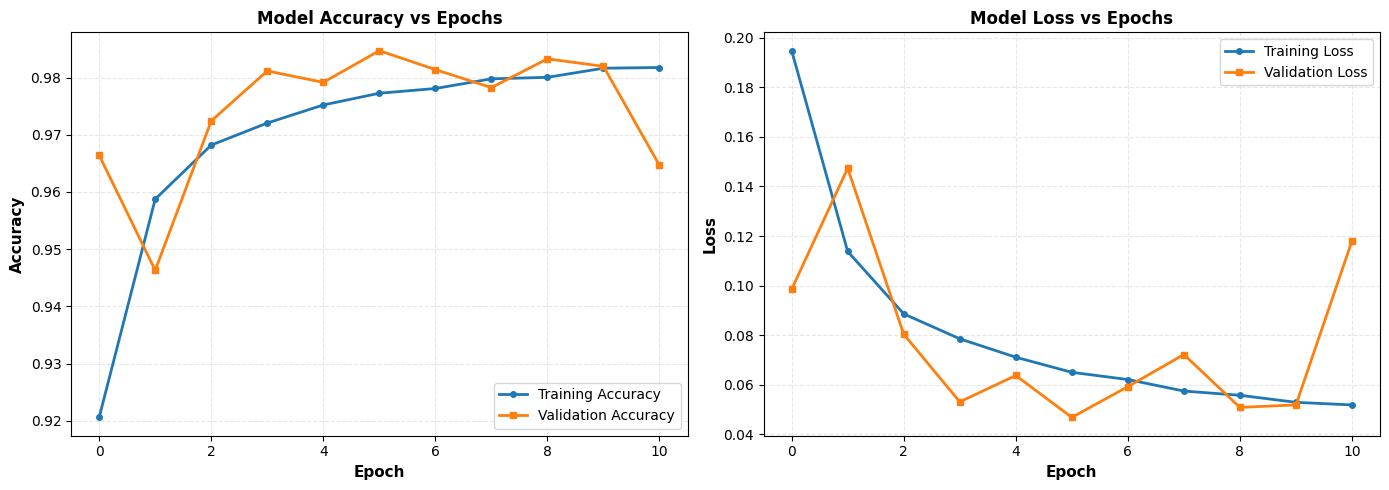

✓ Training history visualization complete

Final Training Results:
  Training Accuracy: 0.9818
  Validation Accuracy: 0.9647
  Training Loss: 0.0519
  Validation Loss: 0.1180


In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0].set_title('Model Accuracy vs Epochs', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[1].set_title('Model Loss vs Epochs', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f"✓ Training history visualization complete")
print(f"\nFinal Training Results:")
print(f"  Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Training Loss: {history.history['loss'][-1]:.4f}")
print(f"  Validation Loss: {history.history['val_loss'][-1]:.4f}")

In [15]:
# Evaluate on unseen test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_binary, verbose=0)

print("=" * 60)
print("TEST SET EVALUATION (Unseen Data)")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("=" * 60)

TEST SET EVALUATION (Unseen Data)
Test Loss: 0.0582
Test Accuracy: 0.9837 (98.37%)


In [16]:
# Generate predictions on test set
y_test_pred_proba = model.predict(X_test_reshaped)
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()

# Generate classification report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT (Test Set)")
print("=" * 70)
print(classification_report(
    y_test_binary,
    y_test_pred,
    target_names=['Normal (0)', 'Abnormal (1)'],
    digits=4
))
print("=" * 70)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

  Normal (0)     0.9865    0.9939    0.9902     18118
Abnormal (1)     0.9698    0.9348    0.9520      3774

    accuracy                         0.9837     21892
   macro avg     0.9781    0.9644    0.9711     21892
weighted avg     0.9836    0.9837    0.9836     21892



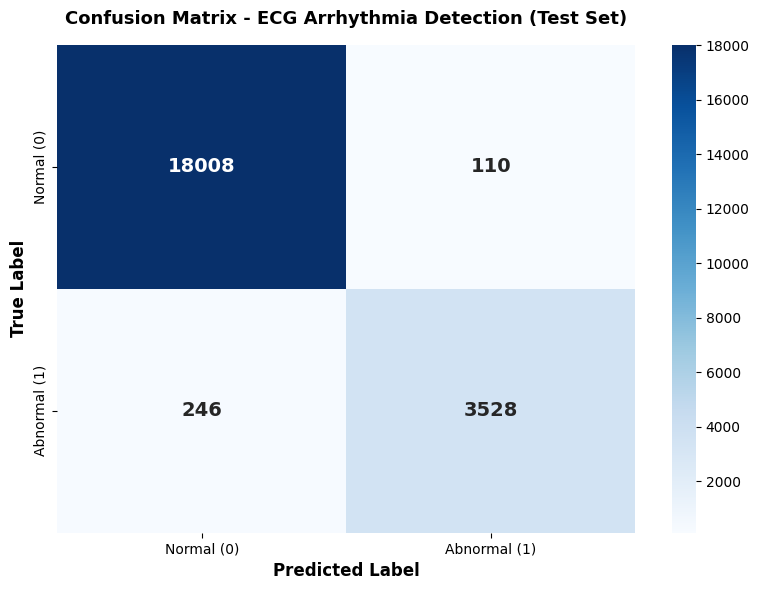


CONFUSION MATRIX ANALYSIS
True Negatives (Normal correctly identified):   18008
False Positives (Normal misclassified):         110
False Negatives (Abnormal misclassified):       246
True Positives (Abnormal correctly identified): 3528

Sensitivity (Recall for Abnormal): 0.9348
Specificity (Recall for Normal):   0.9939


In [17]:
# Compute confusion matrix
cm = confusion_matrix(y_test_binary, y_test_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal (0)', 'Abnormal (1)'],
            yticklabels=['Normal (0)', 'Abnormal (1)'],
            annot_kws={'size': 14, 'weight': 'bold'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - ECG Arrhythmia Detection (Test Set)',
          fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Print confusion matrix analysis
tn, fp, fn, tp = cm.ravel()
print("\n" + "=" * 70)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 70)
print(f"True Negatives (Normal correctly identified):   {tn}")
print(f"False Positives (Normal misclassified):         {fp}")
print(f"False Negatives (Abnormal misclassified):       {fn}")
print(f"True Positives (Abnormal correctly identified): {tp}")
print("=" * 70)
print(f"\nSensitivity (Recall for Abnormal): {tp/(tp+fn):.4f}")
print(f"Specificity (Recall for Normal):   {tn/(tn+fp):.4f}")
print("=" * 70)

In [18]:
# Save the trained model
model_save_path = 'ecg_model_final.keras'
model.save(model_save_path)

print(f"✓ Model saved successfully!")
print(f"  Location: {model_save_path}")
print(f"  File size: {os.path.getsize(model_save_path) / (1024*1024):.2f} MB")

# Verify model can be loaded
loaded_model = keras.models.load_model(model_save_path)
print(f"\n✓ Model verification: Successfully loaded from disk")
print(f"  Model can be used for inference!")

print("\n" + "=" * 70)
print("TRAINING PIPELINE COMPLETE")
print("=" * 70)
print(f"""
✓ All steps completed successfully:
  1. ✓ Data loaded from MIT-BIH Arrhythmia Database
  2. ✓ Binary classification (Normal vs Abnormal)
  3. ✓ Data reshaped for 1D-CNN
  4. ✓ Stratified train-validation split (80-20)
  5. ✓ Class imbalance visualized
  6. ✓ SMOTE applied to training set only
  7. ✓ Balanced classes verified
  8. ✓ 1D-CNN architecture built
  9. ✓ Model compiled (Adam + binary_crossentropy)
  10. ✓ Model trained with EarlyStopping
  11. ✓ Training history plotted
  12. ✓ Evaluated on unseen test set
  13. ✓ Classification report generated
  14. ✓ Confusion matrix visualized
  15. ✓ Model saved as 'ecg_model_final.h5'

Final Test Accuracy: {test_accuracy*100:.2f}%
Ready for deployment!
""")
print("=" * 70)

✓ Model saved successfully!
  Location: ecg_model_final.keras
  File size: 2.59 MB

✓ Model verification: Successfully loaded from disk
  Model can be used for inference!

TRAINING PIPELINE COMPLETE

✓ All steps completed successfully:
  1. ✓ Data loaded from MIT-BIH Arrhythmia Database
  2. ✓ Binary classification (Normal vs Abnormal)
  3. ✓ Data reshaped for 1D-CNN
  4. ✓ Stratified train-validation split (80-20)
  5. ✓ Class imbalance visualized
  6. ✓ SMOTE applied to training set only
  7. ✓ Balanced classes verified
  8. ✓ 1D-CNN architecture built
  9. ✓ Model compiled (Adam + binary_crossentropy)
  10. ✓ Model trained with EarlyStopping
  11. ✓ Training history plotted
  12. ✓ Evaluated on unseen test set
  13. ✓ Classification report generated
  14. ✓ Confusion matrix visualized
  15. ✓ Model saved as 'ecg_model_final.h5'

Final Test Accuracy: 98.37%
Ready for deployment!

